Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import svm
import hashlib
import re


#read from our local copy of the training data
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

train.isnull().sum()

#taking a lot of steps from 
#https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Utilities

In [4]:
#utility to convert one feature of a dataframe to a one-hot dataframe
#input: originaldf (pandas dataframe), feature to remove (string), boolean flag to delete the feature before returning
def onehot_helper(originaldf, feature, remove_original = True):
    
    #turn the categorical data into one-hot dataframe
    dummydf = pd.get_dummies(df[feature],dtype=np.uint8)
    #concatenate the dataframe back onto df
    out = pd.concat([originaldf,dummydf], axis = 1)
    if remove_original:
        originaldf.drop(labels = [feature], inplace = True, axis = 1)
    return(out)
    

Data Processing

In [6]:

#read from our local copy of the training data
df = pd.read_csv('titanic/train.csv')
originaldf = df.copy() #save a copy for later




# #our code is in df
# df.describe(include='all')
# #remove columns with missing data
# df.dropna(subset=[n for n in df if n != 'Cabin'], inplace=True)

# #remove columns we don't need
# #justification - Ticket number and name are both unique, unlikely to find patterns unless we do NLP on the names as a proxy for ethnicity/wealth
# df.drop(labels=['Ticket','Name'],inplace=True,axis=1) #inplace true - we aren't making a copy. axis 1, since we are removing a column not a row


# #turn categorical to quantitative
# df = df.replace(to_replace='male', value=1).replace(to_replace='female', value=0)
# #strip away cabin numbers and just leave the cabin grouping (one of 8 letters)
# df['Cabin'] = df['Cabin'].str[0]
# df = onehot_helper(df, 'Cabin', True)


# df.describe(include='all')



In [54]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def get_fare(fare):
    if fare <= 7.91:
        return 0
    elif fare <= 14.545:
        return 1
    elif fare <= 31:
        return 2
    else:
        return 3

def get_age(age):
    print(age)
    if age <= 16:
        return 0
    elif age <= 32:
        return 1
    elif age <= 48:
        return 2
    elif age <= 64:
        return 3
    else:
        return 4

#process both train and test in sync
full_data = [train, test]
data = train
data.describe(include='all')
print("jdjdjd")
print(data['Age'].value_counts())
print(data['Fare'].value_counts())
#use a lamba to create a new feature indicating whether a person has a cabin listed
data['HasCabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
data['FamSize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = data['FamSize'].apply(lambda x: 1 if x == 1 else 0)

data['Age'] = data['Age'].fillna(data['Age'].median())
data['Age'] = data['Age'].apply(get_age)

data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Fare'] = data['Fare'].apply(get_fare)

data['Sex'] = data['Sex'].apply(lambda x: 0 if x == 'male' else 1)

embark_map = {'S': 0, 'C': 1, 'Q': 2}
data['Embarked'] = data['Embarked'].fillna('S')
data['Embarked'] = data['Embarked'].map(embark_map)

data['Title'] = data['Name'].apply(get_title)
data['Title'] = data['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')
title_map = {'Mr': 1, 'Master': 2, 'Mrs': 3, 'Miss': 4, 'Rare': 5}
data['Title'] = data['Title'].map(title_map)
data['Title'] = data['Title'].fillna(0)

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'] #Ttitle is an artifact, not supposed to be here
data = data.drop(drop_elements, axis = 1)
data.head(3)



jdjdjd
Age
1    523
2    188
0    100
3     69
4     11
Name: count, dtype: int64
Fare
1    234
0    223
3    222
2    212
Name: count, dtype: int64
1
2
1
2
2
1
3
0
1
0
0
3
1
2
0
3
0
1
1
1
2
2
0
1
0
2
1
1
1
1
2
1
1
4
1
2
1
1
1
0
2
1
1
0
1
1
1
1
1
1
0
1
3
1
4
1
1
1
0
0
1
2
2
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
2
0
1
1
1
1
1
2
1
3
1
4
1
2
2
1
1
1
2
2
1
1
1
2
1
2
0
1
1
1
1
4
1
1
0
1
1
2
2
3
0
1
1
1
2
2
1
2
1
1
1
1
2
0
1
1
1
1
1
1
1
1
0
2
2
3
1
3
2
1
3
0
1
1
1
2
2
1
1
0
0
1
2
1
1
3
0
0
1
3
1
1
3
1
2
1
1
0
0
0
1
1
2
2
2
1
1
1
0
2
3
1
2
1
1
1
1
2
2
1
0
1
1
0
2
1
2
1
1
1
1
1
2
1
1
0
1
3
1
2
1
1
1
1
1
2
1
3
0
1
1
2
0
1
2
1
1
1
1
1
2
1
1
2
3
1
1
3
1
2
1
1
1
2
3
1
0
3
2
1
2
0
1
3
2
1
1
2
2
1
3
2
1
0
2
4
1
0
1
1
2
1
1
2
1
1
1
2
1
1
1
1
0
1
3
1
1
1
1
1
0
1
1
1
1
1
1
1
1
2
1
1
3
1
2
1
1
1
1
1
2
3
2
1
0
1
2
2
0
1
1
1
2
2
2
0
1
1
1
2
1
2
1
0
2
1
1
0
1
1
1
1
2
1
1
2
1
2
2
1
1
3
1
1
1
1
1
1
1
0
1
1
1
1
1
2
0
1
2
1
1
0
2
1
1
2
1
1
1
1
1
1
2
1
1
2
1
1
1
1
2
3
0
1
1
1
1
2
1
2
1
2
1
1
0
1
1
1
1
1
1

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,HasCabin,FamSize,IsAlone,Title
0,0,3,1,0,0,0,NaN,0,2,0,1
1,1,1,1,0,0,0,NaN,1,2,0,3
2,1,3,1,0,0,0,NaN,0,1,1,4


Data Visualization

c:\Users\bmand\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bmand\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bmand\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

<Figure size 640x480 with 0 Axes>

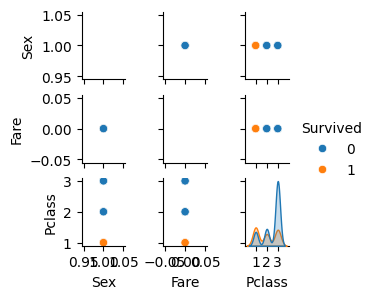

In [61]:

plt.figure()
data.head(3)
train.head(2)
train.describe(include='all')
#df.describe(include="all")
new = data
# plt.figure()
sns.pairplot(new, vars = ['Sex','Fare','Pclass'],hue = "Survived",height = 1)
# plt.show()

#sns.pairplot(df, vars = ['A','B','C','D','E','F','G','T'],hue = "Survived")

plt.show()

Testing